In [23]:
import numpy as np
import tcbench as tcb
import faiss
import matplotlib.pyplot as plt

In [24]:
vectors_baseline = np.load('artifacts-mirage19/baseline_vectors.npy')
labels_baseline = np.load('artifacts-mirage19/baseline_labels.npy')

vectors_embeddings = np.load('artifacts-mirage19/embeddings_vectors.npy')
labels_embeddings = np.load('artifacts-mirage19/embeddings_labels.npy')

In [25]:
df_split = tcb.load_parquet(tcb.DATASETS.MIRAGE19, min_pkts=10, split=True)
train_val_indices = np.concatenate([df_split.iloc[0][0], df_split.iloc[0][1]])
test_indices = df_split.iloc[0][2]

In [26]:
def build_faiss_index(data, labels, train_indices, distance_type, values_per_class):
    np.random.seed(42)

    filtered_data = data[train_indices]
    filtered_labels = labels[train_indices]
    d = filtered_data.shape[1]

    selected_data = []
    selected_indices = []
    unique_labels = np.unique(filtered_labels)
    for label in unique_labels:
        label_indices = np.where(filtered_labels == label)[0]
        if values_per_class is None or values_per_class == -1:
            selected_label_indices = label_indices
        else:
            selected_label_indices = np.random.choice(label_indices, size=min(values_per_class, len(label_indices)), replace=False)
        selected_data.append(filtered_data[selected_label_indices])
        selected_indices.extend(train_indices[selected_label_indices])
    selected_data = np.vstack(selected_data)
    selected_indices = np.array(selected_indices)

    if distance_type == 'euclidean':
        index = faiss.IndexFlatL2(d)
    elif distance_type == 'cosine':
        norms = np.linalg.norm(selected_data, axis=1, keepdims=True)
        selected_data = selected_data / norms
        index = faiss.IndexFlatIP(d)
    else:
        raise ValueError("Unsupported distance type. Use 'euclidean' or 'cosine'.")

    index.add(selected_data)
    return index, selected_indices

In [27]:
def search_and_compare_labels(data, labels, test_indices, selected_indices, index):
    k=5
    D, I = index.search(data[test_indices], k)
    test_labels = labels[test_indices]
    neighbor_labels = labels[selected_indices[I.flatten()]].reshape(I.shape)

    top_1_matches = 0
    top_3_matches = 0
    top_5_matches = 0

    for i in range(len(test_labels)):
        top_1_match = test_labels[i] in neighbor_labels[i, :1]
        top_3_match = test_labels[i] in neighbor_labels[i, :3]
        top_5_match = test_labels[i] in neighbor_labels[i, :5]

        if top_1_match:
            top_1_matches += 1
        if top_3_match:
            top_3_matches += 1
        if top_5_match:
            top_5_matches += 1

    total_tests = len(test_labels)
    top_1_percentage = (top_1_matches / total_tests) * 100
    top_3_percentage = (top_3_matches / total_tests) * 100
    top_5_percentage = (top_5_matches / total_tests) * 100

    return top_1_percentage, top_3_percentage, top_5_percentage

In [28]:
index_baseline, selected_indices = build_faiss_index(vectors_baseline, labels_baseline, train_val_indices, 'euclidean', None)
top_1_baseline, top_3_baseline, top_5_baseline = search_and_compare_labels(vectors_baseline, labels_baseline, test_indices, selected_indices, index_baseline)

print(f"Baseline euclidean match in top 1 neighbor: {top_1_baseline:.2f}%")
print(f"Baseline euclidean match in top 3 neighbors: {top_3_baseline:.2f}%")
print(f"Baseline euclidean match in top 5 neighbors: {top_5_baseline:.2f}%")

Baseline euclidean match in top 1 neighbor: 63.91%
Baseline euclidean match in top 3 neighbors: 74.10%
Baseline euclidean match in top 5 neighbors: 78.09%


In [29]:
index_embeddings, selected_indices = build_faiss_index(vectors_embeddings, labels_embeddings, train_val_indices, 'euclidean', None)
top_1_embeddings, top_3_embeddings, top_5_embeddings = search_and_compare_labels(vectors_embeddings, labels_embeddings, test_indices, selected_indices, index_embeddings)

print(f"Baseline euclidean match in top 1 neighbor: {top_1_embeddings:.2f}%")
print(f"Baseline euclidean match in top 3 neighbors: {top_3_embeddings:.2f}%")
print(f"Baseline euclidean match in top 5 neighbors: {top_5_embeddings:.2f}%")

Baseline euclidean match in top 1 neighbor: 79.39%
Baseline euclidean match in top 3 neighbors: 86.82%
Baseline euclidean match in top 5 neighbors: 89.53%


In [30]:
index_embeddings_cosine, selected_indices = build_faiss_index(vectors_embeddings, labels_embeddings, train_val_indices, 'cosine', None)
top_1_embeddings_cosine, top_3_embeddings_cosine, top_5_embeddings_cosine = search_and_compare_labels(vectors_embeddings, labels_embeddings, test_indices, selected_indices, index_embeddings_cosine)

print(f"Embeddings cosine match in top 1 neighbor: {top_1_embeddings_cosine:.2f}%")
print(f"Embeddings cosine match in top 3 neighbors: {top_3_embeddings_cosine:.2f}%")
print(f"Embeddings cosine match in top 5 neighbors: {top_5_embeddings_cosine:.2f}%")

Embeddings cosine match in top 1 neighbor: 80.82%
Embeddings cosine match in top 3 neighbors: 87.38%
Embeddings cosine match in top 5 neighbors: 90.09%


In [31]:
parameter_values = [5,10,20,30,40,50,60,70,80,90,100,200,300,400,
                    500,600,700,800,900,1000,2000,3000,4000,5000]

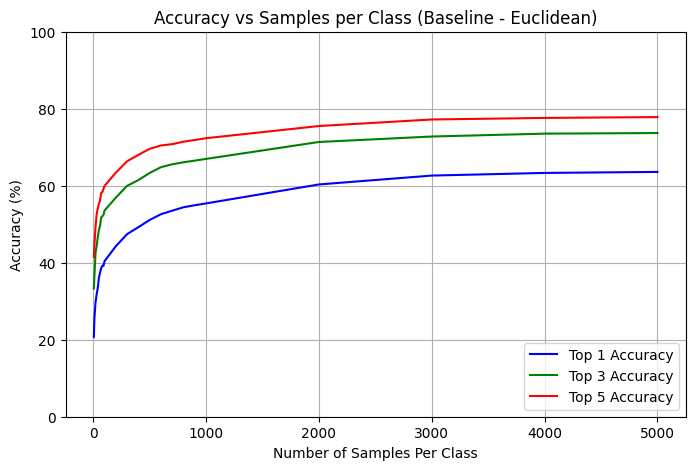

In [32]:
top_1_accuracies_baseline = []
top_3_accuracies_baseline = []
top_5_accuracies_baseline = []

for param in parameter_values:
    index_baseline, selected_indices = build_faiss_index(vectors_baseline, labels_baseline, train_val_indices, 'euclidean', param)
    top_1_baseline, top_3_baseline, top_5_baseline = search_and_compare_labels(vectors_baseline, labels_baseline, test_indices, selected_indices, index_baseline)
    
    top_1_accuracies_baseline.append(top_1_baseline)
    top_3_accuracies_baseline.append(top_3_baseline)
    top_5_accuracies_baseline.append(top_5_baseline)

plt.figure(figsize=(8, 5))
plt.plot(parameter_values, top_1_accuracies_baseline, label='Top 1 Accuracy', color='blue')
plt.plot(parameter_values, top_3_accuracies_baseline, label='Top 3 Accuracy', color='green')
plt.plot(parameter_values, top_5_accuracies_baseline, label='Top 5 Accuracy', color='red')

plt.xlabel('Number of Samples Per Class')
plt.ylim([0, 100])
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Samples per Class (Baseline - Euclidean)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

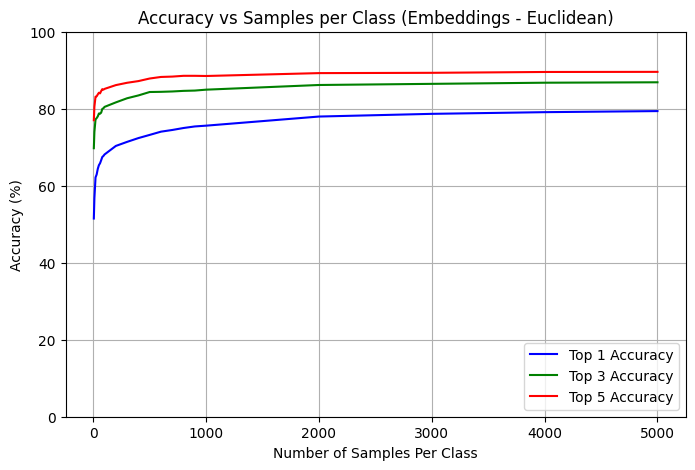

In [33]:
top_1_accuracies_embeddings = []
top_3_accuracies_embeddings = []
top_5_accuracies_embeddings = []

for param in parameter_values:
    index_embeddings, selected_indices = build_faiss_index(vectors_embeddings, labels_embeddings, train_val_indices, 'euclidean', param)
    top_1_embeddings, top_3_embeddings, top_5_embeddings = search_and_compare_labels(vectors_embeddings, labels_embeddings, test_indices, selected_indices, index_embeddings)
    
    top_1_accuracies_embeddings.append(top_1_embeddings)
    top_3_accuracies_embeddings.append(top_3_embeddings)
    top_5_accuracies_embeddings.append(top_5_embeddings)

plt.figure(figsize=(8, 5))
plt.plot(parameter_values, top_1_accuracies_embeddings, label='Top 1 Accuracy', color='blue')
plt.plot(parameter_values, top_3_accuracies_embeddings, label='Top 3 Accuracy', color='green')
plt.plot(parameter_values, top_5_accuracies_embeddings, label='Top 5 Accuracy', color='red')

plt.xlabel('Number of Samples Per Class')
plt.ylim([0, 100])
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Samples per Class (Embeddings - Euclidean)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

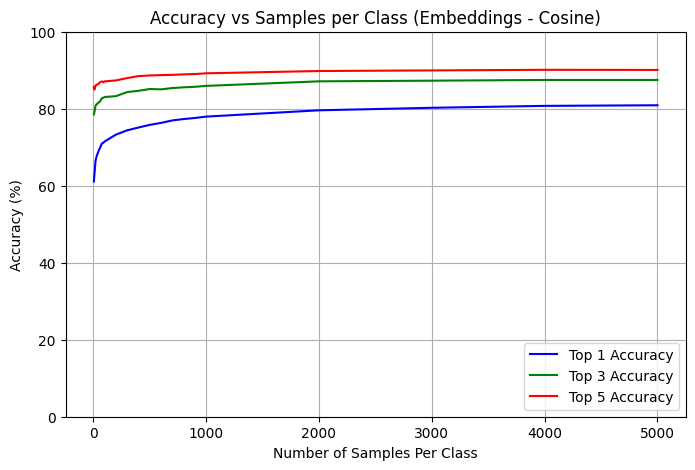

In [34]:
top_1_accuracies_embeddings_cosine = []
top_3_accuracies_embeddings_cosine = []
top_5_accuracies_embeddings_cosine = []

for param in parameter_values:
    index_embeddings_cosine, selected_indices = build_faiss_index(vectors_embeddings, labels_embeddings, train_val_indices, 'cosine', param)
    top_1_embeddings_cosine, top_3_embeddings_cosine, top_5_embeddings_cosine = search_and_compare_labels(vectors_embeddings, labels_embeddings, test_indices, selected_indices, index_embeddings_cosine)
    
    top_1_accuracies_embeddings_cosine.append(top_1_embeddings_cosine)
    top_3_accuracies_embeddings_cosine.append(top_3_embeddings_cosine)
    top_5_accuracies_embeddings_cosine.append(top_5_embeddings_cosine)

plt.figure(figsize=(8, 5))
plt.plot(parameter_values, top_1_accuracies_embeddings_cosine, label='Top 1 Accuracy', color='blue')
plt.plot(parameter_values, top_3_accuracies_embeddings_cosine, label='Top 3 Accuracy', color='green')
plt.plot(parameter_values, top_5_accuracies_embeddings_cosine, label='Top 5 Accuracy', color='red')

plt.xlabel('Number of Samples Per Class')
plt.ylim([0, 100])
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Samples per Class (Embeddings - Cosine)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

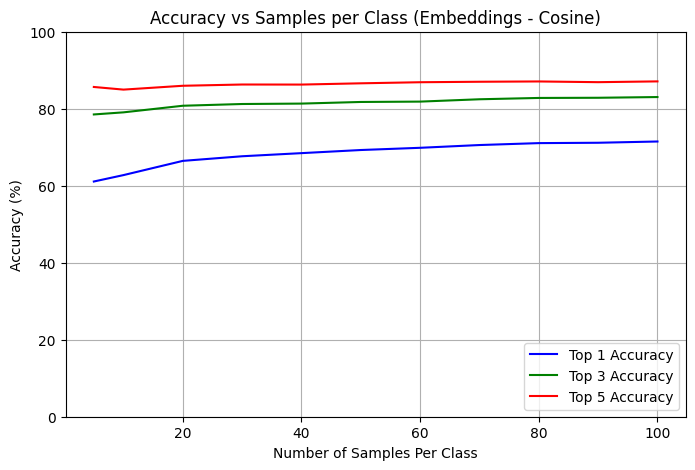

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(parameter_values[:11], top_1_accuracies_embeddings_cosine[:11], label='Top 1 Accuracy', color='blue')
plt.plot(parameter_values[:11], top_3_accuracies_embeddings_cosine[:11], label='Top 3 Accuracy', color='green')
plt.plot(parameter_values[:11], top_5_accuracies_embeddings_cosine[:11], label='Top 5 Accuracy', color='red')

plt.xlabel('Number of Samples Per Class')
plt.ylim([0, 100])
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Samples per Class (Embeddings - Cosine)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()